In [10]:
'''Train a Siamese MLP on pairs of digits from the MNIST dataset.
It follows Hadsell-et-al.'06 [1] by computing the Euclidean distance on the
output of the shared network and by optimizing the contrastive loss (see paper
for mode details).
[1] "Dimensionality Reduction by Learning an Invariant Mapping"
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
Gets to 99.5% test accuracy after 20 epochs.
3 seconds per epoch on a Titan X GPU
'''
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.optimizers import RMSprop
from keras import backend as K


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1  #Finding the least number of images amongst all digits
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]     # Appending a positive pair ( Images of the same digit)
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10           # Selecting a random digit other than d. This is to create the negative pair
            z1, z2 = digit_indices[d][i], digit_indices[dn][i] 
            pairs += [[x[z1], x[z2]]]     # Appending the negative pair
            labels += [1, 0]  #Since we append a positive and then a negative pair, we append labels 1 and then 0
    return np.array(pairs), np.array(labels)


def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(128, input_shape=(input_dim,), activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    return seq


def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()

In [3]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
input_dim = 784
nb_epoch = 20

In [5]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

In [4]:
digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test, digit_indices)

# network definition
base_network = create_base_network(input_dim)

In [6]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [9]:
[len(digit_indices[i]) for i in range(10)]

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]

In [13]:
tr_pairs.shape

(108400, 2, 784)

In [16]:
import matplotlib.pyplot as plt

%matplotlib inline

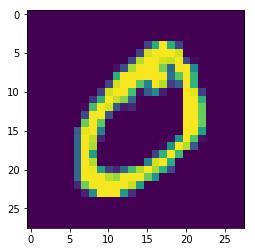

In [17]:
plt.imshow(tr_pairs[0,0,:].reshape(28,28))

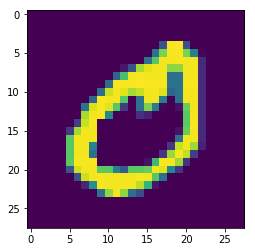

In [18]:
plt.imshow(tr_pairs[0,1,:].reshape(28,28))

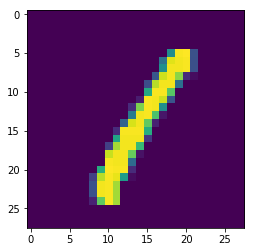

In [20]:
plt.imshow(tr_pairs[1,1,:].reshape(28,28))

In [21]:
input_a = Input(shape=(input_dim,))
input_b = Input(shape=(input_dim,))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

In [22]:
processed_a.shape

TensorShape([Dimension(None), Dimension(128)])

In [23]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(input=[input_a, input_b], output=distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y),
          batch_size=128,
          nb_epoch=nb_epoch)

# compute final accuracy on training and test sets
pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("la..., inputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # This is added back by InteractiveShellApp.init_path()


Train on 108400 samples, validate on 17820 samples
Epoch 1/20
108400/108400 [==============================] - 16s 152us/step - loss: 0.0941 - val_loss: 0.0430
Epoch 2/20
108400/108400 [==============================] - 3s 30us/step - loss: 0.0400 - val_loss: 0.0294
Epoch 3/20
108400/108400 [==============================] - 3s 29us/step - loss: 0.0274 - val_loss: 0.0264
Epoch 4/20
108400/108400 [==============================] - 3s 30us/step - loss: 0.0220 - val_loss: 0.0257
Epoch 5/20
108400/108400 [==============================] - 3s 30us/step - loss: 0.0189 - val_loss: 0.0238
Epoch 6/20
108400/108400 [==============================] - 3s 31us/step - loss: 0.0171 - val_loss: 0.0236
Epoch 7/20
108400/108400 [==============================] - 3s 30us/step - loss: 0.0152 - val_loss: 0.0235
Epoch 8/20
108400/108400 [==============================] - 3s 30us/step - loss: 0.0144 - val_loss: 0.0229
Epoch 9/20
108400/108400 [==============================] - 4s 35us/step - loss: 0.0133 - v